## 0. Spatial Patterns and Segregation

In [82]:
#!pip install -U kaleido
#import kaleido
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
import plotly.express as px
import json
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from segregation.singlegroup import absolute_clustering, dissim, interaction,absolute_concentration, delta, absolute_centralization
import geopandas as gpd
import plotly.io as pio

In this notebook, we look at the spatial patterns of immigrants in terms of population density.

### 1. Densities by census tract

In [83]:
#Read all years of padron
directory = './data/residents_by_cob/ine/'

file_names = os.listdir(directory)
csv_files = [file for file in file_names if file.endswith('.csv')]

dfs = []
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path,sep='\t',thousands=r'.')
    df['year'] = file.replace('.csv', '')
    dfs.append(df)

# Concatenate all DataFrames
big_df = pd.concat(dfs, ignore_index=True)

In [84]:
big_df=big_df[(big_df.Sexo=='Ambos Sexos') & (big_df['Sección']!='TOTAL')]
big_df=big_df.drop('Sexo',axis=1)

In [85]:
#Add total census population as a different column
census_pop = big_df[big_df['País de nacimiento']=='Total Población']
census_pop=census_pop.drop('País de nacimiento',axis=1).rename(columns={'Total':'census_total_pob'})
big_df=big_df.merge(census_pop, on=['Sección','year'], how='left')
big_df=big_df[big_df['País de nacimiento']!='Total Población']

In [86]:
#Column names
big_df.columns=['cusec','cob','population','year','census_total_pop']
big_df=big_df[['year','cusec','cob','population','census_total_pop']]

In [87]:
big_df.population=big_df.population.astype(int)
big_df.census_total_pop=big_df.census_total_pop.astype(int)

In [88]:
#Make corrections
big_df.cob=big_df.cob.replace({'República Dominicana':'Rep. Dominicana'})

In [89]:
big_df.cusec=big_df.cusec.astype(int)

In [90]:
#Crosswalk extracted from the CUSECS shapefile
crosswalk=pd.read_csv('./data/geography/census_tracts_muns_districts.csv')

In [91]:
crosswalk=crosswalk[crosswalk.NPRO=='Barcelona']

In [92]:
muns_of_comarca=['Barcelona',"Hospitalet de Llobregat, L'",'Badalona','Santa Coloma de Gramenet','Sant Adrià de Besòs']

In [93]:
crosswalk=crosswalk[crosswalk.NMUN.isin(muns_of_comarca)]

In [94]:
comarca=big_df.merge(crosswalk, left_on='cusec',right_on='CUSEC',how='inner')

**Map of Barcelona County**

We used QGIS to create a shapefile just for the county of Barcelona

Tutorial from: https://chart-studio.plotly.com/~empet/15238/tips-to-extract-data-from-a-geojson-di/#/

In [95]:
#Change coordinate system
#gdf = gpd.read_file("./data/geography/cusecs/comarca_reduced.shp", encoding='utf-8')
#gdf=gdf.to_crs(epsg=4326)
#gdf.to_file('./data/geography/cusecs/spain_comarcas.json', driver = 'GeoJSON')

In [96]:
with open('./data/geography/cusecs/spain_comarcas.json', encoding='utf-8') as geofile:
    jdataNo = json.load(geofile)

**Map 1: 2012 vs 2022, All Immigrants**

In [97]:
mapping = gpd.read_file('./data/geography/cusecs/spain_comarcas.json')
comarca['CUSEC']='0'+comarca['CUSEC'].astype(str)
mapping=mapping.merge(comarca,  on='CUSEC', how='left')

immigrants = mapping[mapping['cob'] == 'Nacidos en el Extranjero']
immigrants['density'] = immigrants['population'] / immigrants['census_total_pop']
immigrants['cusec'] = ('0' + immigrants['cusec'].astype(str)).astype(str)
immigrants12 = immigrants[immigrants['year'] == '2012']
immigrants22 = immigrants[immigrants['year'] == '2022']

In [98]:
immigrants12.density=immigrants12.density*100
immigrants22.density=immigrants22.density*100

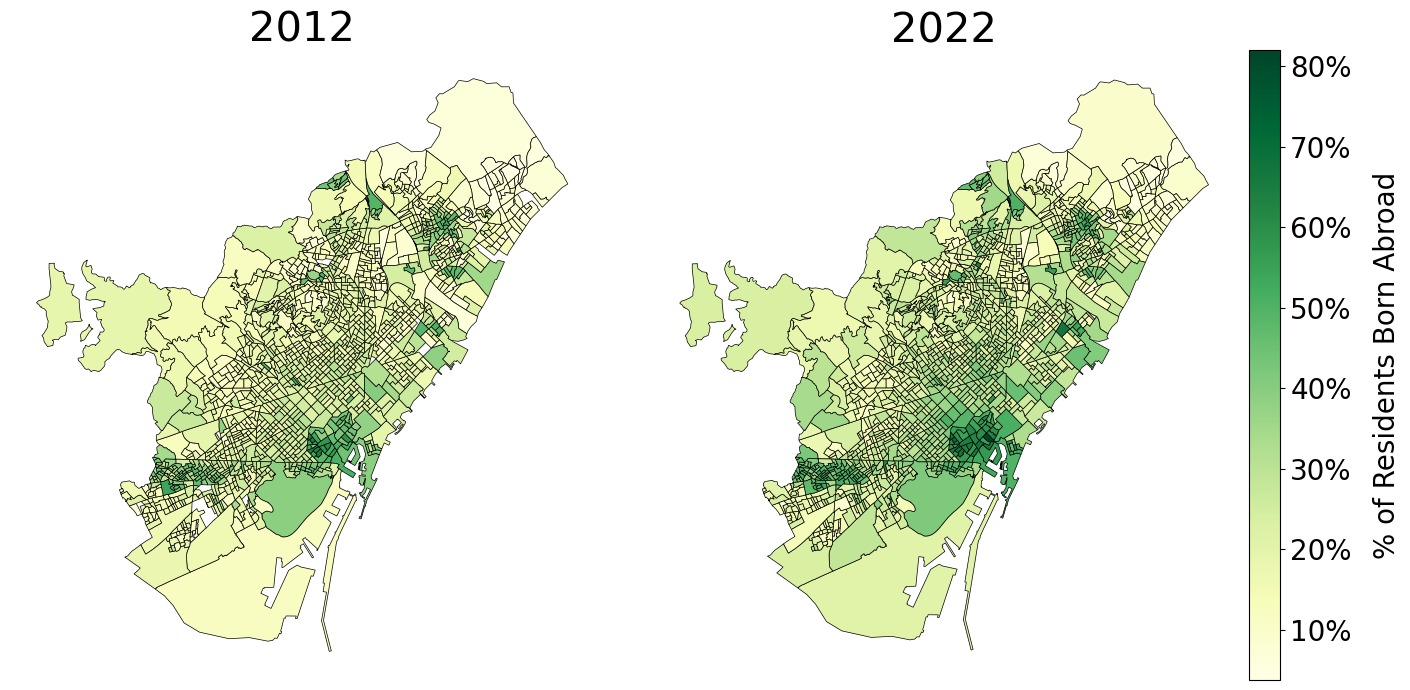

In [99]:
# Plot
import matplotlib.ticker as ticker

fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True, linewidth=0.5)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

# Plot 2012
immigrants12.plot(column='density', cmap='YlGn', legend=False, ax=axs[0], edgecolor='black', vmax=82, linewidth=0.5)
axs[0].set_title('2012', fontsize=30)
axs[0].set_axis_off()

# Plot 2022
img = immigrants22.plot(column='density', cmap='YlGn', legend=False, ax=axs[1], edgecolor='black', vmax=82, linewidth=0.5)
axs[1].set_title('2022', fontsize=30)
axs[1].set_axis_off()

formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%")
cbar = fig.colorbar(img.collections[0], ax=axs[1], orientation='vertical', pad=0.02, format=formatter)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('% of Residents Born Abroad', fontsize=20, labelpad=15)

plt.tight_layout()

plt.savefig('./figures/overall_density_2012_2022.png', dpi=200, bbox_inches='tight')

plt.show()


**Map 2: Evolution of comarca population by nationality**

In [100]:
total_yearly_pop=comarca.groupby(['year','cob'])['population'].sum().reset_index()

In [101]:
selected_nationalities=['Alemania', 'Senegal', 'Argelia', 'Polonia', 'Portugal', 'Reino Unido',
       'Rumanía', 'Rusia',  'Pakistán', 'Ucrania', 'Uruguay',
       'Venezuela', 'Paraguay', 'Perú', 'Oceanía y Apátridas', 'Nigeria',
       'Argentina', 'Bolivia', 'Brasil', 'Bulgaria', 'Chile', 'China',
       'Colombia', 'Cuba', 'Ecuador', 'Francia', 'Italia',
       'Marruecos','Rep. Dominicana','Rest of Europe']
total_yearly_pop_pivot=total_yearly_pop[total_yearly_pop.cob.isin(selected_nationalities)].pivot(index='year', columns='cob', values='population').T

In [102]:
translations = {'Alemania': 'Germany', 'Senegal': 'Senegal', 'Argelia': 'Algeria', 'Polonia': 'Poland', 'Portugal': 'Portugal', 'Reino Unido': 'United Kingdom', 'Rumanía': 'Romania', 'Rusia': 'Russia', 'Pakistán': 'Pakistan', 'Ucrania': 'Ukraine', 'Uruguay': 'Uruguay', 'Venezuela': 'Venezuela', 'Paraguay': 'Paraguay', 'Perú': 'Peru', 'Oceanía y Apátridas': 'Oceania and Stateless', 'Nigeria': 'Nigeria', 'Argentina': 'Argentina', 'Bolivia': 'Bolivia', 'Brasil': 'Brazil', 'Bulgaria': 'Bulgaria', 'Chile': 'Chile', 'China': 'China', 'Colombia': 'Colombia', 'Cuba': 'Cuba', 'Ecuador': 'Ecuador', 'Francia': 'France', 'Italia': 'Italy', 'Marruecos': 'Morocco', 'Rep. Dominicana': 'Dominican Republic'}


In [103]:
total_yearly_pop_pivot.sort_values('2022', ascending=False).head(20)

year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
cob,,,,,,,,,,,,
Ecuador,44048,43742,42795,43856,42628,42256,42097,41726,42233,43048,42469,42773
Perú,31186,31600,31082,31303,30981,31034,31927,33060,35518,38960,39089,40767
Pakistán,32273,34392,32324,31612,31049,31491,32091,31909,34179,38163,39291,40478
Argentina,25089,24596,23923,23508,23485,23825,24805,26169,28804,33861,34907,39440
Colombia,23435,24271,23880,23647,23634,23900,25586,26932,30019,35037,35932,38387
Marruecos,29563,30234,29783,30753,30811,31098,31503,31803,33693,36770,36629,37145
Venezuela,8893,9568,9700,9940,11193,12954,15573,19159,23798,29085,29752,31246
China,22104,22792,22275,22365,23448,24884,26400,27244,28631,31426,30225,29635
Bolivia,24723,24276,23554,24106,23643,23472,23917,24257,24923,25439,25164,25523


In [153]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Grouping by year and country of birth, and summing up the population
total_yearly_pop = comarca.groupby(['year', 'cob'])['population'].sum().reset_index()

total_yearly_pop.cob=total_yearly_pop.cob.replace(translations)

# Define the selected nationalities for each group
latin_american = ['Ecuador', 'Peru', 'Argentina', 'Venezuela', 'Bolivia']
european = ['Italy', 'France', 'Germany', 'Romania']
others = ['China', 'Pakistan', 'Morocco']

# Create subplots
fig = make_subplots(rows=1, cols=3,    subplot_titles=(
        "<span style='font-size:20px'>Latin American</span>", 
        "<span style='font-size:20px'>European</span>", 
        "<span style='font-size:20px'>Asian and African</span>"
    ),  shared_yaxes=True)

# Add traces for Latin American countries
for i, col in enumerate(latin_american):
    latin_data = total_yearly_pop[total_yearly_pop['cob'] == col]
    fig.add_trace(go.Scatter(x=latin_data['year'], y=latin_data['population'], mode='lines', name=col, legendgroup='latin', legendgrouptitle={'text': 'Latin American'}), row=1, col=1)

# Add traces for European countries
for i, col in enumerate(european):
    european_data = total_yearly_pop[total_yearly_pop['cob'] == col]
    fig.add_trace(go.Scatter(x=european_data['year'], y=european_data['population'], mode='lines', name=col, legendgroup='european', legendgrouptitle={'text': 'European'}), row=1, col=2)

# Add traces for Other countries
for i, col in enumerate(others):
    other_data = total_yearly_pop[total_yearly_pop['cob'] == col]
    fig.add_trace(go.Scatter(x=other_data['year'], y=other_data['population'], mode='lines', name=col, legendgroup='others', legendgrouptitle={'text': 'Asian and African'}), row=1, col=3)

fig.update_layout(margin=dict(t=25),
                  plot_bgcolor='rgba(0,0,0,0)', 
                  paper_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(linecolor='black', linewidth=1, showgrid=False),
                  yaxis=dict(linecolor='black', linewidth=1, showgrid=False, showticklabels=True, title='Population in Barcelona county'),
                  xaxis2=dict(linecolor='black', linewidth=1, showgrid=False),
                  yaxis2=dict(linecolor='black', linewidth=1, showgrid=False, showticklabels=True),
                  xaxis3=dict(linecolor='black', linewidth=1, showgrid=False),
                  yaxis3=dict(linecolor='black', linewidth=1, showgrid=False, showticklabels=True),
                  legend=dict(orientation="h",yanchor="bottom",y=-0.7,xanchor="left",x=0.25,font=dict(size=18),
                              itemwidth=30),
                 )
fig.update_layout(
    font=dict(size=18, color="black"),
)


fig.update_layout( height=600, width=1000)
fig.write_image("./figures/evolution_by_nation.png", scale=2)
fig.show()


**Densities by nation**

In [24]:
#Add % of census population
comarca['perc_population']=comarca.population/comarca.census_total_pop

In [25]:
mapping = gpd.read_file('./data/geography/cusecs/spain_comarcas.json')
mapping=mapping.merge(comarca,  on='CUSEC', how='left')

In [28]:
comarca[comarca.cob=='China'].perc_population.max()

0.22562141491395793

In [30]:
comarca[(comarca.cob=='China') & (comarca.perc_population>0.2)]

,year,cusec,cob,population,census_total_pop,CUSEC,CUMUN,CSEC,CDIS,CMUN,...,NPRO,NCA,CNUT0,CNUT1,CNUT2,CNUT3,NMUN,area,dist_plcat,perc_population
647169,2011,824506008,China,345,1544,0824506008,8245,8,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,46389.039,8008.821,0.223446
647205,2012,824506008,China,354,1569,0824506008,8245,8,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,46389.039,8008.821,0.225621
648357,2020,824506011,China,437,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.225026


In [33]:
comarca[(comarca.cusec==824506011) & (comarca.year=='2020')]

,year,cusec,cob,population,census_total_pop,CUSEC,CUMUN,CSEC,CDIS,CMUN,...,NPRO,NCA,CNUT0,CNUT1,CNUT2,CNUT3,NMUN,area,dist_plcat,perc_population
648324,2020,824506011,Nacidos en España,843,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.434089
648325,2020,824506011,Nacidos en el Extranjero,1099,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.565911
648326,2020,824506011,Total Unión Europea,26,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.013388
648327,2020,824506011,Alemania,2,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.001030
648328,2020,824506011,Bulgaria,0,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.000000
648329,2020,824506011,Francia,1,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.000515
648330,2020,824506011,Italia,3,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.001545
648331,2020,824506011,Polonia,0,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.000000
648332,2020,824506011,Portugal,0,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.000000
648333,2020,824506011,Reino Unido,2,1942,0824506011,8245,11,6,245,...,Barcelona,Cataluña,ES,5,1,1,Santa Coloma de Gramenet,32353.249,8056.874,0.001030


Ecuador

In [45]:
to_plot=mapping[(mapping.year=='2021') & (mapping.cob=='Ecuador')]

In [46]:
to_plot.perc_population=to_plot.perc_population*100

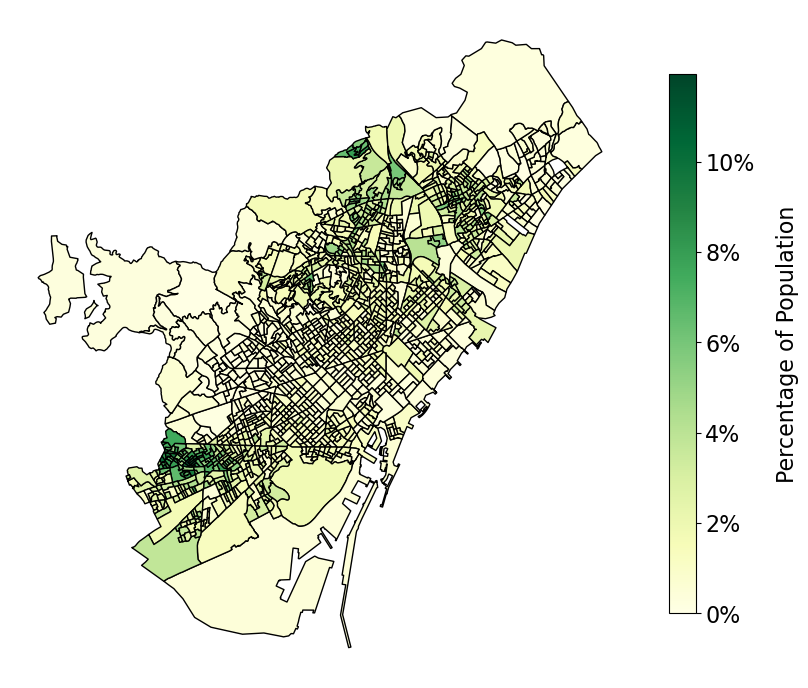

In [47]:
# Plot
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
to_plot.plot(column='perc_population', cmap='YlGn', legend=False, ax=ax, edgecolor='black', linewidth=1,)  # Set vmin and vmax to ensure correct color scaling

# Customize color bar ticks
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%")
cbar = ax.get_figure().colorbar(ax.collections[0], format=formatter, shrink=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Percentage of Population', fontsize=16, labelpad=15)

# Remove axes
ax.set_axis_off()

# Show plot
plt.savefig('./figures/density_ecuador.png', dpi=200, bbox_inches='tight')
plt.show()

Italia

In [48]:
to_plot=mapping[(mapping.year=='2021') & (mapping.cob=='Italia')]

In [49]:
to_plot.perc_population=to_plot.perc_population*100

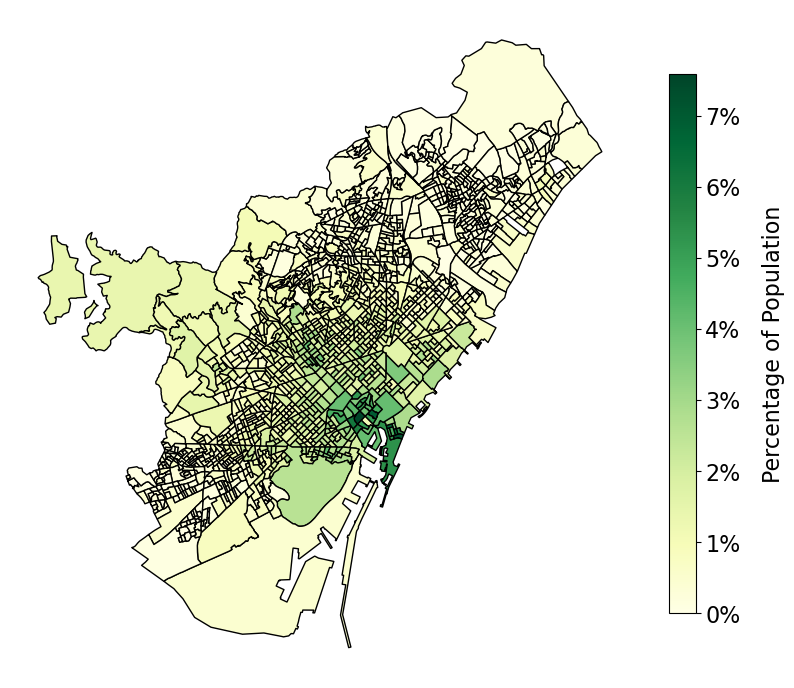

In [50]:
# Plot
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
to_plot.plot(column='perc_population', cmap='YlGn', legend=False, ax=ax, edgecolor='black', linewidth=1,)  # Set vmin and vmax to ensure correct color scaling

# Customize color bar ticks
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%")
cbar = ax.get_figure().colorbar(ax.collections[0], format=formatter, shrink=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Percentage of Population', fontsize=16, labelpad=15)

# Remove axes
ax.set_axis_off()

# Show plot
plt.savefig('./figures/density_italia.png', dpi=200, bbox_inches='tight')
plt.show()

Morroco

In [51]:
to_plot=mapping[(mapping.year=='2021') & (mapping.cob=='Marruecos')]

In [52]:
to_plot.perc_population=to_plot.perc_population*100

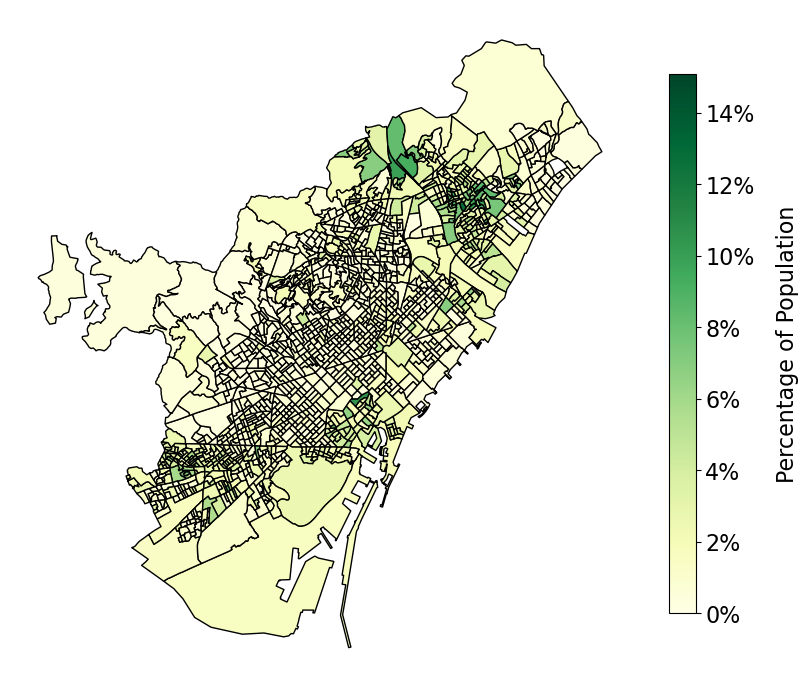

In [53]:
# Plot
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
to_plot.plot(column='perc_population', cmap='YlGn', legend=False, ax=ax, edgecolor='black', linewidth=1,)  # Set vmin and vmax to ensure correct color scaling

# Customize color bar ticks
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%")
cbar = ax.get_figure().colorbar(ax.collections[0], format=formatter, shrink=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Percentage of Population', fontsize=16, labelpad=15)

# Remove axes
ax.set_axis_off()

# Show plot
plt.savefig('./figures/density_morroco.png', dpi=200, bbox_inches='tight')
plt.show()

China

In [54]:
to_plot=mapping[(mapping.year=='2021') & (mapping.cob=='China')]

In [55]:
to_plot.perc_population=to_plot.perc_population*100

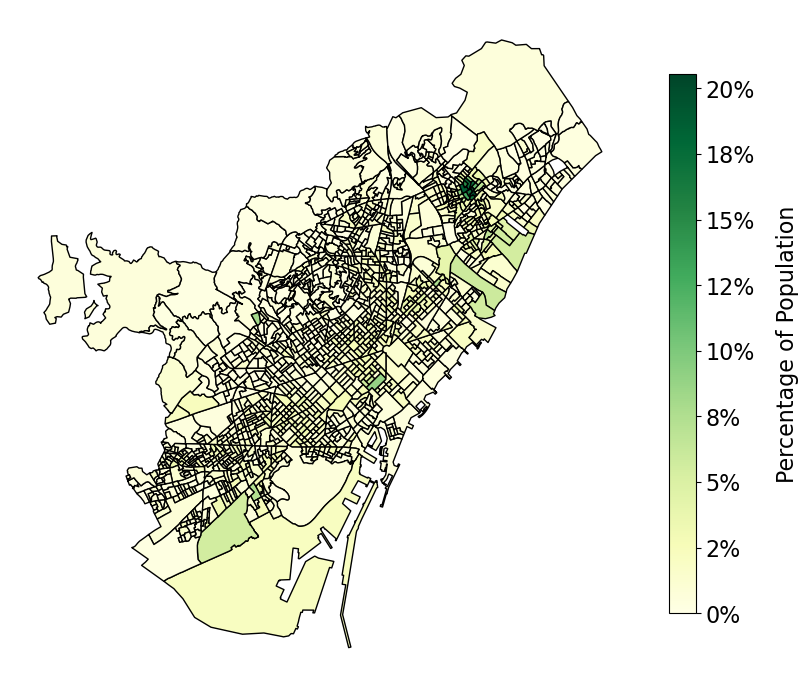

In [56]:
# Plot
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
to_plot.plot(column='perc_population', cmap='YlGn', legend=False, ax=ax, edgecolor='black', linewidth=1,)  # Set vmin and vmax to ensure correct color scaling

# Customize color bar ticks
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%")
cbar = ax.get_figure().colorbar(ax.collections[0], format=formatter, shrink=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Percentage of Population', fontsize=16, labelpad=15)

# Remove axes
ax.set_axis_off()

# Show plot
plt.savefig('./figures/density_china.png', dpi=200, bbox_inches='tight')
plt.show()

Pakistan

In [57]:
to_plot=mapping[(mapping.year=='2021') & (mapping.cob=='Pakistán')]

In [58]:
to_plot.perc_population=to_plot.perc_population*100

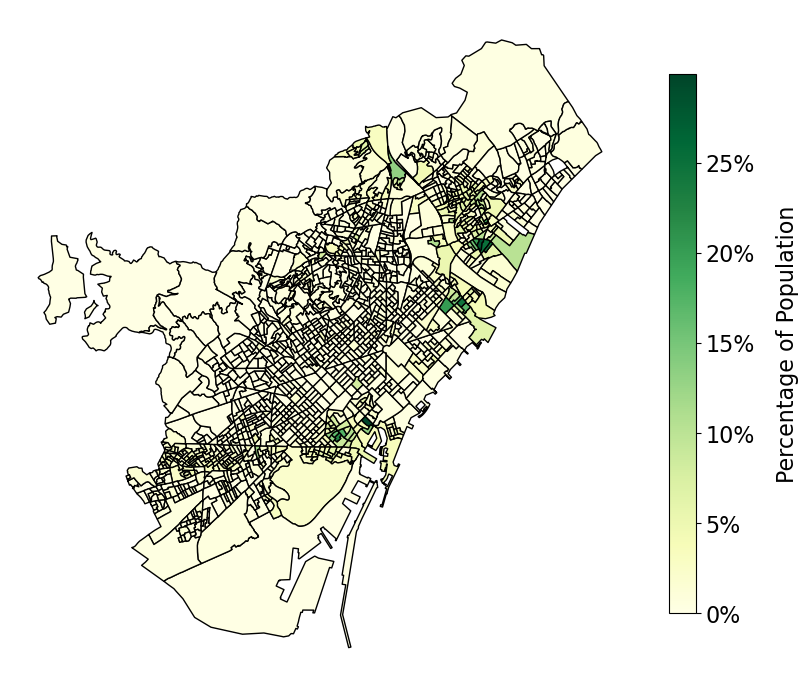

In [59]:
# Plot
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
to_plot.plot(column='perc_population', cmap='YlGn', legend=False, ax=ax, edgecolor='black', linewidth=1,)  # Set vmin and vmax to ensure correct color scaling

# Customize color bar ticks
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%")
cbar = ax.get_figure().colorbar(ax.collections[0], format=formatter, shrink=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Percentage of Population', fontsize=16, labelpad=15)

# Remove axes
ax.set_axis_off()

# Show plot
plt.savefig('./figures/density_pakistan.png', dpi=200, bbox_inches='tight')
plt.show()

Republica Dominicana

In [60]:
to_plot=mapping[(mapping.year=='2021') & (mapping.cob=='Rep. Dominicana')]

In [61]:
to_plot.perc_population=to_plot.perc_population*100

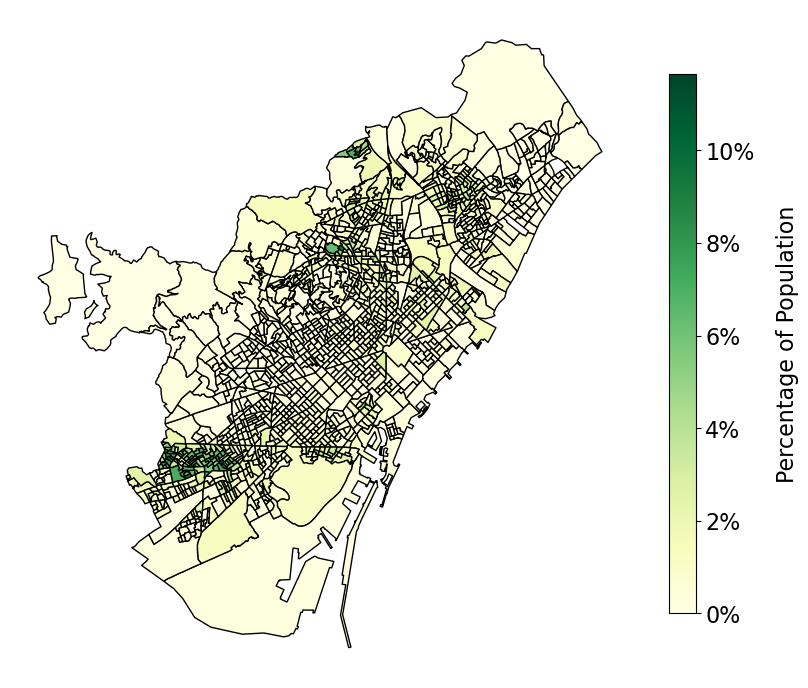

In [62]:
# Plot
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
to_plot.plot(column='perc_population', cmap='YlGn', legend=False, ax=ax, edgecolor='black', linewidth=1,)  # Set vmin and vmax to ensure correct color scaling

# Customize color bar ticks
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%")
cbar = ax.get_figure().colorbar(ax.collections[0], format=formatter, shrink=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Percentage of Population', fontsize=16, labelpad=15)

# Remove axes
ax.set_axis_off()

# Show plot
plt.savefig('./figures/density_dominican.png', dpi=200, bbox_inches='tight')
plt.show()

### 2. Hierarchical Clustering

In [63]:
#Nice tutorial: https://www.kaggle.com/code/kevzzsk/hierarchical-clustering
#Paper for selecting k: https://www.researchgate.net/publication/377256908_Inertia-based_indices_to_determine_the_number_of_clusters_in_K-means_an_experimental_evaluation

In [64]:
total_yearly_pop=comarca.groupby(['year','cob'])['population'].sum().reset_index()
selected_nationalities=['Alemania', 'Senegal', 'Argelia', 'Polonia', 'Portugal', 'Reino Unido',
       'Rumanía', 'Rusia',  'Pakistán', 'Ucrania', 'Uruguay',
       'Venezuela', 'Paraguay', 'Perú', 'Oceanía y Apátridas', 'Nigeria',
       'Argentina', 'Bolivia', 'Brasil', 'Bulgaria', 'Chile', 'China',
       'Colombia', 'Cuba', 'Ecuador', 'Francia', 'Italia',
       'Marruecos','Rep. Dominicana','Rest of Europe']
total_yearly_pop_pivot=total_yearly_pop[total_yearly_pop.cob.isin(selected_nationalities)].pivot(index='year', columns='cob', values='population').T
total_yearly_pop_pivot.sort_values('2022', ascending=False).head(20).index

Index(['Ecuador', 'Perú', 'Pakistán', 'Argentina', 'Colombia', 'Marruecos',
       'Venezuela', 'China', 'Bolivia', 'Rep. Dominicana', 'Italia', 'Francia',
       'Brasil', 'Rusia', 'Reino Unido', 'Chile', 'Rumanía', 'Alemania',
       'Paraguay', 'Cuba'],
      dtype='object', name='cob')

In [65]:
#Choose the top 20 nationalities as per 2022
top20=['Ecuador', 'Perú', 'Pakistán', 'Argentina', 'Colombia', 'Marruecos',
       'Venezuela', 'China', 'Bolivia', 'Rep. Dominicana', 'Italia', 'Francia',
       'Brasil', 'Rusia', 'Reino Unido', 'Chile', 'Rumanía', 'Alemania',
       'Paraguay', 'Cuba']
df_clus=comarca[(comarca.cob.isin(top20)) & (comarca.year=='2022')]

In [66]:
#Pivot it
df_clus=df_clus.pivot(index='cusec', columns='cob', values='population').T
df_clus.head()

cusec,801501001,801501002,801501003,801501004,801501005,801501007,801502001,801502002,801502003,801502004,...,824505019,824506002,824506003,824506004,824506005,824506008,824506009,824506011,824506012,824506014
cob,,,,,,,,,,,,,,,,,,,,,
Alemania,3,2,2,6,5,2,3,7,5,5,...,2,1,0,0,0,3,0,1,0,2
Argentina,14,11,12,13,20,11,24,18,7,26,...,5,3,3,2,9,8,2,5,13,6
Bolivia,4,4,1,2,7,2,8,13,1,4,...,24,21,31,8,16,59,31,56,33,36
Brasil,3,13,3,2,2,1,10,3,2,5,...,11,12,1,3,3,29,11,14,18,27
Chile,1,9,0,4,4,4,3,3,2,10,...,10,2,0,0,4,3,10,2,2,3


**Experiment 0**: Eucledian Distance, Ward (No Normalization,it goes wrong, see Italy which has too high base rates)

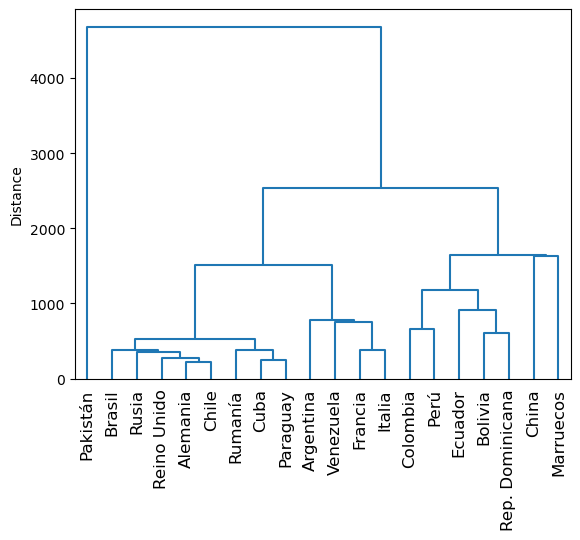

In [67]:
# Perform hierarchical clustering
Z = linkage(df_clus, method='ward', metric='euclidean')
 
# Plot dendrogram
dendrogram(Z, color_threshold=30, labels=df_clus.index, leaf_rotation=90, leaf_font_size=12)
plt.ylabel('Distance')
plt.show()

**Experiment 1**: Eucledian Distance, Ward (with Normalization)

In [68]:
# Standardize your data
scaler = StandardScaler()
   #Standardization happens Nation by Nation, not CUSEC by CUSEC /this would attenuate Italy's dominance/
df_clus_standardized = scaler.fit_transform(df_clus.T).T

# Perform hierarchical clustering using Euclidean distance on standardized data
Z = linkage(df_clus_standardized, method='ward', metric='euclidean')

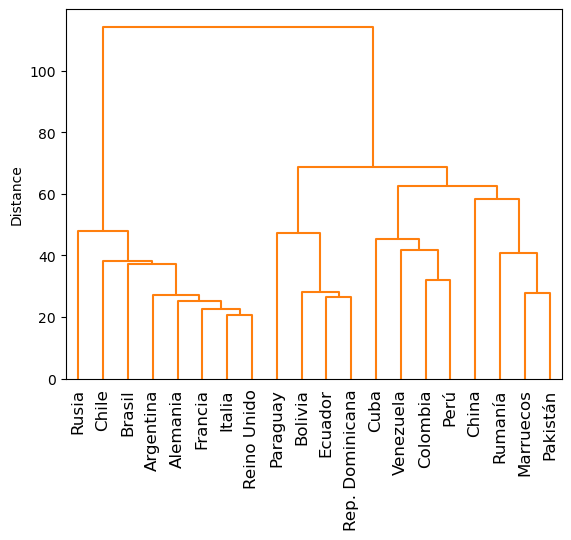

In [69]:
# Plot dendrogram
dendrogram(Z, color_threshold=500, labels=df_clus.index, leaf_rotation=90, leaf_font_size=12)
plt.ylabel('Distance')
plt.show()

In [70]:
X = df_clus_standardized

Inertia /  Within Distance Gradient

In [71]:
sse = {}
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=1,  n_init=100).fit(X)
    sse[k] = kmeans.inertia_

In [72]:
sse_table=pd.DataFrame.from_dict(sse, orient='index').reset_index()
sse_table.columns=['k','SSE']
sse_table

,k,SSE
0,2,14949.624230
1,3,12557.297018
2,4,10841.288815
3,5,9135.305502
4,6,8034.075440
5,7,6926.657893
6,8,5934.098093
7,9,5046.839175
8,10,4218.118586
9,11,3494.446990


In [73]:
sse_table['EL1'] = (sse_table['SSE'].shift(1) - sse_table['SSE']) / (sse_table['SSE'] - sse_table['SSE'].shift(-1))
sse_table

,k,SSE,EL1
0,2,14949.624230,NaN
1,3,12557.297018,1.394123
2,4,10841.288815,1.005876
3,5,9135.305502,1.549162
4,6,8034.075440,0.994413
5,7,6926.657893,1.115719
6,8,5934.098093,1.118681
7,9,5046.839175,1.070637
8,10,4218.118586,1.145161
9,11,3494.446990,NaN


In [74]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, subplot_titles=["Within-Cluster Sum of Squared Errors", "EL1 Criterium"], column_widths=[0.5, 0.5])

fig.add_trace(go.Scatter(x=sse_table.k, y=sse_table.SSE, mode='lines', name='WSS', showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=sse_table.k, y=sse_table['EL1'], mode='lines', name='El1', showlegend=False), row=1, col=2)

fig.update_xaxes(title_text="Number of Clusters", row=1, col=1, linecolor='black', linewidth=2)
fig.update_yaxes(title_text="WSS", row=1, col=1, linecolor='black', linewidth=2)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2, linecolor='black', linewidth=2)
fig.update_yaxes(title_text="EL1", row=1, col=2, linecolor='black', linewidth=2)

font_size = 20
fig.update_layout(xaxis=dict(title=dict(font=dict(size=font_size)), tickfont=dict(size=font_size)), yaxis=dict(title=dict(font=dict(size=font_size)), tickfont=dict(size=font_size)), xaxis2=dict(title=dict(font=dict(size=font_size)), tickfont=dict(size=font_size)), yaxis2=dict(title=dict(font=dict(size=font_size)), tickfont=dict(size=font_size)), margin=dict(t=50, b=0, l=0, r=0), title=dict(font=dict(size=font_size + 4)), plot_bgcolor='rgba(0,0,0,0)')

fig.update_annotations(font=dict(size=font_size + 2))  # Increase size of subplot titles
fig.update_layout( height=500, width=1000)

fig.write_image("./figures/clustering_k.png", scale=2)
fig.show()  # Display the figure using Plotly



Final Dendorgram

In [75]:
translations = {'Alemania': 'Germany', 'Senegal': 'Senegal', 'Argelia': 'Algeria', 'Polonia': 'Poland',
                'Portugal': 'Portugal', 'Reino Unido': 'United Kingdom', 'Rumanía': 'Romania', 'Rusia': 'Russia',
                'Pakistán': 'Pakistan', 'Ucrania': 'Ukraine', 'Uruguay': 'Uruguay', 'Venezuela': 'Venezuela',
                'Paraguay': 'Paraguay', 'Perú': 'Peru', 'Oceanía y Apátridas': 'Oceania and Stateless', 
                'Nigeria': 'Nigeria', 'Argentina': 'Argentina', 'Bolivia': 'Bolivia', 'Brasil': 'Brazil',
                'Bulgaria': 'Bulgaria', 'Chile': 'Chile', 'China': 'China', 'Colombia': 'Colombia',
                'Cuba': 'Cuba', 'Ecuador': 'Ecuador', 'Francia': 'France', 'Italia': 'Italy', 
                'Marruecos': 'Morocco', 'Rep. Dominicana': 'Dominican Republic'}


In [76]:
df_clus.index=pd.Series(df_clus.index).replace(translations)

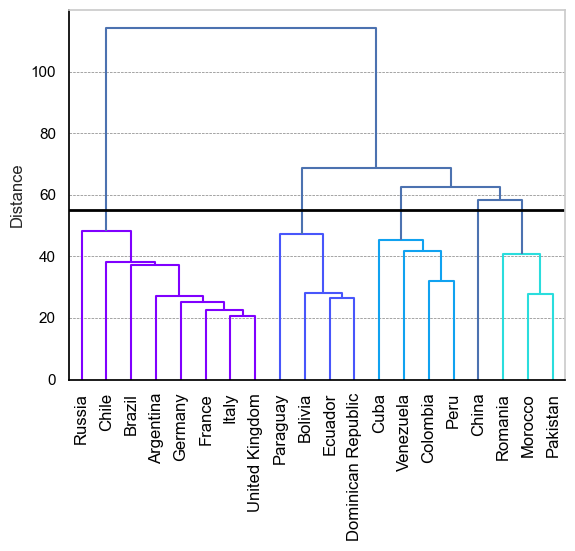

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib.pyplot import cm

cmap = cm.rainbow(np.linspace(0, 1, 10))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Set seaborn style
sns.set(style='whitegrid')

# Plot dendrogram
dendrogram(Z, color_threshold=49, labels=df_clus.index, leaf_rotation=90, leaf_font_size=12)
plt.ylabel('Distance')
plt.tick_params(axis='x', colors='black')  # Set color of x-axis ticks to black
plt.tick_params(axis='y', colors='black')  # Set color of y-axis ticks to black
plt.gca().spines['bottom'].set_color('black')  # Set color of the bottom axis line to black
plt.gca().spines['left'].set_color('black')    # Set color of the left axis line to black
plt.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)  # Add horizontal grid lines

# Turn off vertical grid lines
plt.grid(False, axis='x')
plt.axhline(y=55, color='black', linewidth=2)

plt.savefig('./figures/clustering_dendogram.png', dpi=300, bbox_inches='tight')

plt.show()


In [181]:
comarca

,year,cusec,cob,population,census_total_pop,CUSEC,CUMUN,CSEC,CDIS,CMUN,...,NPRO,NCA,CNUT0,CNUT1,CNUT2,CNUT3,NMUN,area,dist_plcat,perc_population
0,2011,801501001,Nacidos en España,1312,1375,0801501001,8015,1,1,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,140808.524,9160.482,0.954182
1,2011,801501001,Nacidos en el Extranjero,63,1375,0801501001,8015,1,1,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,140808.524,9160.482,0.045818
2,2011,801501001,Total Unión Europea,18,1375,0801501001,8015,1,1,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,140808.524,9160.482,0.013091
3,2011,801501001,Alemania,2,1375,0801501001,8015,1,1,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,140808.524,9160.482,0.001455
4,2011,801501001,Bulgaria,0,1375,0801501001,8015,1,1,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,140808.524,9160.482,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653611,2022,801505008,Venezuela,0,832,0801505008,8015,8,5,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,181541.719,10393.775,0.000000
653612,2022,801505008,Total Asia,7,832,0801505008,8015,8,5,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,181541.719,10393.775,0.008413
653613,2022,801505008,China,4,832,0801505008,8015,8,5,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,181541.719,10393.775,0.004808
653614,2022,801505008,Pakistán,3,832,0801505008,8015,8,5,15,...,Barcelona,Cataluña,ES,5,1,1,Badalona,181541.719,10393.775,0.003606


## 3. Dimensions of Residential Segregation

In [85]:
top20=['Ecuador', 'Perú', 'Pakistán', 'Argentina', 'Colombia', 'Marruecos',
       'Venezuela', 'China', 'Bolivia', 'Rep. Dominicana', 'Italia', 'Francia',
       'Brasil', 'Rusia', 'Reino Unido', 'Chile', 'Rumanía', 'Alemania',
       'Paraguay', 'Cuba']

### 1. Evenness: Dissimilarity index

In [86]:
def dissimilarity(df, nation, year):
    red_df=df[(df.year==year) & (df.cob==nation) ]
    T=red_df.census_total_pop.sum()
    P=red_df.population.sum()/T
    sum_over_cusecs=0
    for cusec in set(red_df.cusec):
        t_i = red_df[red_df.cusec==cusec].census_total_pop.values[0]
        p_i = red_df[red_df.cusec==cusec].population.values[0]/t_i
        #Numerator
        sum_over_cusecs += t_i*abs(p_i-P)
    #Denominator
    denom=2*T*P*(1-P)
    return sum_over_cusecs/denom

In [87]:
#HIGHER = MORE SEGREGATED
for nation in top20:
    print(f"{nation}: DIS {round(dissimilarity(comarca,nation,'2022'),3)}")

Ecuador: DIS 0.354
Perú: DIS 0.277
Pakistán: DIS 0.552
Argentina: DIS 0.32
Colombia: DIS 0.226
Marruecos: DIS 0.405
Venezuela: DIS 0.255
China: DIS 0.354
Bolivia: DIS 0.375
Rep. Dominicana: DIS 0.423
Italia: DIS 0.393
Francia: DIS 0.366
Brasil: DIS 0.292
Rusia: DIS 0.313
Reino Unido: DIS 0.447
Chile: DIS 0.323
Rumanía: DIS 0.326
Alemania: DIS 0.363
Paraguay: DIS 0.381
Cuba: DIS 0.3


Let's double check this with the dissim package.

In [88]:
def dissimilarity_2(df, nation, year):
    
    # Read the shapefile
    gdf = gpd.read_file("./data/geography/cusecs/comarca_reduced.shp")
    gdf.CUSEC=gdf.CUSEC.astype(int)

    #Project to EPSG
    gdf = gdf.to_crs("EPSG:25830")

    #Add population details
    gdf = gdf.merge(df[(df.year==year) & (df.cob==nation) ][['cusec','population','census_total_pop']],left_on='CUSEC',right_on='cusec',how='left')

    #Calculate D
    index = dissim.Dissim(gdf, 'population', 'census_total_pop')
    return index.statistic

In [89]:
for nation in top20:
     print(f"{nation}: DIS {round(dissimilarity_2(comarca,nation,'2022'),3)}")

Ecuador: DIS 0.354
Perú: DIS 0.277
Pakistán: DIS 0.552
Argentina: DIS 0.32
Colombia: DIS 0.226
Marruecos: DIS 0.405
Venezuela: DIS 0.255
China: DIS 0.354
Bolivia: DIS 0.375
Rep. Dominicana: DIS 0.423
Italia: DIS 0.393
Francia: DIS 0.366
Brasil: DIS 0.292
Rusia: DIS 0.313
Reino Unido: DIS 0.447
Chile: DIS 0.323
Rumanía: DIS 0.326
Alemania: DIS 0.363
Paraguay: DIS 0.381
Cuba: DIS 0.3


### 2. Exposure: Interaction Index

In [90]:
def interaction(df, nation, year):
    red_df=df[(df.year==year) & (df.cob==nation) ]
    majority_df= df[(df.year==year) & (df.cob=='Nacidos en España') ] 
    #Minority pop total
    X=red_df.population.sum()
    sum_over_cusecs=0
    for cusec in set(red_df.cusec):
        #Minority pop cusec
        x_i = red_df[red_df.cusec==cusec].population.values[0]
        #Majority pop cusec
        y_i = majority_df[majority_df.cusec==cusec].population.values[0]
        #Total pop in cusec
        t_i = red_df[red_df.cusec==cusec].census_total_pop.values[0]
        #add 
        sum_over_cusecs += (x_i/X)*(y_i/t_i)
    return sum_over_cusecs

In [91]:
#HIGHER : MORE MINGLED WITH SPANISH
for nation in top20:
    print(f"{nation}: DIS {round(interaction(comarca,nation,'2022'),3)}")

Ecuador: DIS 0.663
Perú: DIS 0.678
Pakistán: DIS 0.553
Argentina: DIS 0.677
Colombia: DIS 0.673
Marruecos: DIS 0.632
Venezuela: DIS 0.692
China: DIS 0.688
Bolivia: DIS 0.65
Rep. Dominicana: DIS 0.634
Italia: DIS 0.658
Francia: DIS 0.679
Brasil: DIS 0.683
Rusia: DIS 0.688
Reino Unido: DIS 0.651
Chile: DIS 0.677
Rumanía: DIS 0.661
Alemania: DIS 0.678
Paraguay: DIS 0.681
Cuba: DIS 0.696


*We won't use the Interaction library here - they interpret the majority population as "Total - Minority", while we are comparing with Spanish nationals*

### 3. Concentration: Delta

In [92]:
def delta_idx(df, nation, year):
    
    # Read the shapefile
    gdf = gpd.read_file("./data/geography/cusecs/comarca_reduced.shp")
    gdf.CUSEC=gdf.CUSEC.astype(int)

    #Project to EPSG
    gdf = gdf.to_crs("EPSG:25830")

    #Add population details
    gdf = gdf.merge(df[(df.year==year) & (df.cob==nation) ][['cusec','population','census_total_pop']],left_on='CUSEC',right_on='cusec',how='left')

    gdf = gdf[~gdf.population.isna()]
    #Calculate Delta
    index = delta.Delta(gdf, 'population', 'census_total_pop')
    return index.statistic

In [93]:
for nation in top20:
     print(f"{nation}: {round(delta_idx(comarca,nation,'2022'),3)}")

Ecuador: 0.651
Perú: 0.626
Pakistán: 0.738
Argentina: 0.608
Colombia: 0.602
Marruecos: 0.627
Venezuela: 0.6
China: 0.643
Bolivia: 0.663
Rep. Dominicana: 0.692
Italia: 0.636
Francia: 0.6
Brasil: 0.594
Rusia: 0.561
Reino Unido: 0.647
Chile: 0.625
Rumanía: 0.613
Alemania: 0.597
Paraguay: 0.664
Cuba: 0.614


### 4. Centralization: Absolute Centralization

In [94]:
def ace_idx(df, nation, year):
    
    # Read the shapefile
    gdf = gpd.read_file("./data/geography/cusecs/comarca_reduced.shp")
    gdf.CUSEC=gdf.CUSEC.astype(int)

    #Project to EPSG
    gdf = gdf.to_crs("EPSG:25830")

    #Add population details
    gdf = gdf.merge(df[(df.year==year) & (df.cob==nation) ][['cusec','population','census_total_pop']],left_on='CUSEC',right_on='cusec',how='left')

    gdf = gdf[~gdf.population.isna()]
    #Let's make Pl Catalunya the center
    #Calculate ACE
    index = absolute_centralization.AbsoluteCentralization(gdf, 'population', 'census_total_pop',  center=[2.170051799215122, 41.387049750981326])
    return index.statistic

In [95]:
for nation in top20:
     print(f"{nation}: {round(ace_idx(comarca,nation,'2022'),3)}")

Ecuador: 0.031
Perú: 0.08
Pakistán: -0.047
Argentina: 0.12
Colombia: 0.067
Marruecos: -0.048
Venezuela: 0.071
China: -0.068
Bolivia: 0.122
Rep. Dominicana: 0.118
Italia: 0.167
Francia: 0.151
Brasil: 0.07
Rusia: 0.029
Reino Unido: 0.173
Chile: 0.109
Rumanía: 0.031
Alemania: 0.133
Paraguay: 0.047
Cuba: 0.042


### 5. Clustering: Absolute Clustering Index

In [96]:
def clustering(df, nation, year):
    
    # Read the shapefile
    gdf = gpd.read_file("./data/geography/cusecs/comarca_reduced.shp")
    gdf.CUSEC=gdf.CUSEC.astype(int)

    #Project to EPSG
    gdf = gdf.to_crs("EPSG:25830")

    #Add population details
    gdf = gdf.merge(df[(df.year==year) & (df.cob==nation) ][['cusec','population','census_total_pop']],left_on='CUSEC',right_on='cusec',how='left')

    #Only the part with population
    gdf = gdf[~gdf.population.isna()]
    
    #Calculate ACL
    index = absolute_clustering.AbsoluteClustering(gdf, 'population', 'census_total_pop', alpha = 0.6, beta = 0.5)
    return index.statistic

In [97]:
#Minimum 0, maximum (but never equal) to 1
for nation in top20:
     print(f"{nation}: {round(clustering(comarca,nation,'2022'),3)}")

Ecuador: 0.009
Perú: 0.005
Pakistán: 0.078
Argentina: 0.005
Colombia: 0.005
Marruecos: 0.016
Venezuela: 0.003
China: 0.014
Bolivia: 0.008
Rep. Dominicana: 0.01
Italia: 0.005
Francia: 0.004
Brasil: 0.002
Rusia: 0.003
Reino Unido: 0.004
Chile: 0.002
Rumanía: 0.004
Alemania: 0.002
Paraguay: 0.002
Cuba: 0.001


### Time Series of Indices

In [98]:
all_years=list(set(comarca.year))
all_years.sort()

**Evenness: Dissimilarity index**

In [99]:
evenness_ts=pd.DataFrame(columns=all_years)

In [ ]:
for nation in top20:
    all_nation=[]
    for one_year in all_years:
        all_nation.append(round(dissimilarity(comarca,nation,one_year),3))
    evenness_ts.loc[nation]=all_nation

In [101]:
#evenness_ts.to_csv('C:/Users/gregb/Desktop/TFM/checkpoints/evenness_ts.csv')

**Exposure: Interaction Index**

In [122]:
interaction_ts=pd.DataFrame(columns=all_years)

In [126]:
for nation in top20:
    all_nation=[]
    for one_year in all_years:
        all_nation.append(round(interaction(comarca,nation,one_year),3))
    print(all_nation)
    interaction_ts.loc[nation]=all_nation

[0.738, 0.733, 0.735, 0.73, 0.729, 0.724, 0.714, 0.704, 0.69, 0.672, 0.67, 0.663]
[0.764, 0.759, 0.758, 0.755, 0.753, 0.748, 0.738, 0.728, 0.712, 0.691, 0.688, 0.678]
[0.597, 0.611, 0.625, 0.635, 0.636, 0.633, 0.627, 0.617, 0.599, 0.565, 0.56, 0.553]
[0.769, 0.763, 0.76, 0.758, 0.754, 0.748, 0.735, 0.728, 0.712, 0.69, 0.688, 0.677]
[0.77, 0.765, 0.763, 0.762, 0.758, 0.753, 0.741, 0.732, 0.714, 0.689, 0.685, 0.673]
[0.715, 0.712, 0.715, 0.716, 0.715, 0.71, 0.7, 0.69, 0.672, 0.647, 0.642, 0.632]
[0.775, 0.77, 0.767, 0.766, 0.763, 0.756, 0.745, 0.737, 0.723, 0.701, 0.701, 0.692]
[0.755, 0.75, 0.752, 0.755, 0.754, 0.749, 0.74, 0.733, 0.72, 0.697, 0.696, 0.688]
[0.734, 0.731, 0.733, 0.725, 0.723, 0.717, 0.705, 0.693, 0.678, 0.66, 0.658, 0.65]
[0.716, 0.713, 0.715, 0.709, 0.705, 0.698, 0.687, 0.675, 0.659, 0.642, 0.64, 0.634]
[0.743, 0.735, 0.731, 0.728, 0.723, 0.716, 0.704, 0.699, 0.685, 0.667, 0.668, 0.658]
[0.769, 0.762, 0.758, 0.755, 0.751, 0.746, 0.734, 0.728, 0.714, 0.696, 0.694, 0.679

In [103]:
#interaction_ts.to_csv('C:/Users/gregb/Desktop/TFM/checkpoints/interaction_ts.csv')

**Concentration: Delta**

In [128]:
concentration_ts=pd.DataFrame(columns=all_years)

In [115]:
for nation in top20:
    all_nation=[]
    for one_year in all_years:
        all_nation.append(round(delta_idx(comarca,nation,one_year),3))
    print(all_nation)
    concentration_ts.loc[nation]=all_nation

[0.664, 0.664, 0.663, 0.669, 0.664, 0.662, 0.66, 0.66, 0.658, 0.656, 0.654, 0.651]
[0.647, 0.643, 0.64, 0.642, 0.639, 0.639, 0.637, 0.635, 0.635, 0.632, 0.629, 0.626]
[0.785, 0.774, 0.76, 0.755, 0.75, 0.744, 0.741, 0.74, 0.738, 0.742, 0.739, 0.738]
[0.607, 0.604, 0.604, 0.602, 0.6, 0.602, 0.601, 0.601, 0.604, 0.606, 0.607, 0.608]
[0.616, 0.614, 0.609, 0.608, 0.606, 0.603, 0.602, 0.602, 0.603, 0.605, 0.602, 0.602]
[0.642, 0.639, 0.634, 0.633, 0.629, 0.628, 0.628, 0.627, 0.624, 0.628, 0.626, 0.627]
[0.627, 0.633, 0.63, 0.625, 0.625, 0.623, 0.619, 0.617, 0.609, 0.605, 0.604, 0.6]
[0.675, 0.668, 0.663, 0.663, 0.66, 0.655, 0.654, 0.646, 0.641, 0.645, 0.644, 0.643]
[0.655, 0.659, 0.659, 0.665, 0.661, 0.661, 0.661, 0.663, 0.662, 0.663, 0.662, 0.663]
[0.694, 0.69, 0.683, 0.687, 0.688, 0.696, 0.694, 0.697, 0.696, 0.693, 0.694, 0.692]
[0.651, 0.653, 0.652, 0.652, 0.654, 0.655, 0.649, 0.641, 0.639, 0.635, 0.634, 0.636]
[0.587, 0.59, 0.594, 0.592, 0.593, 0.594, 0.597, 0.597, 0.598, 0.599, 0.598, 0

In [117]:
#concentration_ts.to_csv('C:/Users/gregb/Desktop/TFM/checkpoints/concentration_ts.csv')

**Centralization: Absolute Centralization Index**

In [121]:
centralization_ts=pd.DataFrame(columns=all_years)

In [122]:
for nation in top20:
    all_nation=[]
    for one_year in all_years:
        all_nation.append(round(ace_idx(comarca,nation,one_year),3))
    print(all_nation)
    centralization_ts.loc[nation]=all_nation

[0.014, 0.017, 0.015, 0.046, 0.046, 0.049, 0.05, 0.047, 0.041, 0.032, 0.025, 0.031]
[0.09, 0.091, 0.087, 0.101, 0.1, 0.098, 0.099, 0.096, 0.091, 0.087, 0.079, 0.08]
[-0.018, -0.017, -0.012, -0.004, 0.005, 0.004, -0.0, -0.009, -0.021, -0.034, -0.04, -0.047]
[0.1, 0.103, 0.103, 0.106, 0.107, 0.109, 0.109, 0.106, 0.109, 0.116, 0.115, 0.12]
[0.074, 0.078, 0.078, 0.084, 0.084, 0.084, 0.081, 0.075, 0.069, 0.07, 0.063, 0.067]
[-0.053, -0.052, -0.056, -0.04, -0.039, -0.038, -0.04, -0.046, -0.044, -0.051, -0.057, -0.048]
[0.118, 0.122, 0.119, 0.116, 0.112, 0.112, 0.105, 0.095, 0.086, 0.076, 0.073, 0.071]
[-0.097, -0.092, -0.075, -0.055, -0.045, -0.047, -0.041, -0.044, -0.044, -0.062, -0.071, -0.068]
[0.1, 0.095, 0.093, 0.123, 0.12, 0.125, 0.126, 0.129, 0.125, 0.122, 0.118, 0.122]
[0.101, 0.099, 0.093, 0.119, 0.123, 0.129, 0.128, 0.127, 0.123, 0.114, 0.113, 0.118]
[0.186, 0.191, 0.195, 0.195, 0.197, 0.197, 0.196, 0.189, 0.183, 0.175, 0.168, 0.167]
[0.142, 0.143, 0.146, 0.149, 0.149, 0.151, 0.152

In [123]:
#centralization_ts.to_csv('C:/Users/gregb/Desktop/TFM/checkpoints/centralization_ts.csv')


**Clustering: Absolute Clustering Index**

In [134]:
clustering_ts=pd.DataFrame(columns=all_years)

In [135]:
for nation in top20:
    all_nation=[]
    for one_year in all_years:
        all_nation.append(round(clustering(comarca,nation,one_year),3))
    clustering_ts.loc[nation]=all_nation

In [109]:
#clustering_ts.to_csv('C:/Users/gregb/Desktop/TFM/checkpoints/clustering_ts.csv')

Plots

In [180]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px

# Load data
evenness_ts = pd.read_csv('C:/Users/gregb/Desktop/TFM/checkpoints/evenness_ts.csv', index_col=0)
interaction_ts = pd.read_csv('C:/Users/gregb/Desktop/TFM/checkpoints/interaction_ts.csv', index_col=0)
concentration_ts = pd.read_csv('C:/Users/gregb/Desktop/TFM/checkpoints/concentration_ts.csv', index_col=0)
centralization_ts = pd.read_csv('C:/Users/gregb/Desktop/TFM/checkpoints/centralization_ts.csv', index_col=0)
clustering_ts = pd.read_csv('C:/Users/gregb/Desktop/TFM/checkpoints/clustering_ts.csv', index_col=0)

# Define selected nationalities
selected_nationalities = ['Ecuador', 'Pakistán', 'Marruecos', 'China','Rep. Dominicana']
english_translations = {
    'Ecuador': 'Ecuador',
    'Pakistán': 'Pakistan',
    'Marruecos': 'Morocco',
    'China': 'China',
    'Rep. Dominicana':'Dominican Rep.'
}

# Define colors for each country
colors = px.colors.qualitative.Set1[:len(selected_nationalities)]

# Initialize subplots
fig = make_subplots(rows=3, cols=2, specs=[[{}, {}], [{}, {}], [{"colspan": 2}, None]],
                    subplot_titles=("Dissimilarity Index", "Interaction Index", "Relative Concentration Index", "Relative Centralization Index", "Absolute Clustering Index"))

# Add traces for each index
for index, ts in enumerate([evenness_ts, interaction_ts, concentration_ts, centralization_ts]):
    table_to_plot = ts.loc[selected_nationalities].unstack().reset_index()
    table_to_plot.columns = ['year', 'nation', 'value']
    for i, nation in enumerate(selected_nationalities):
        english_name = english_translations[nation]
        fig.add_trace(
            go.Scatter(x=table_to_plot[table_to_plot['nation'] == nation]['year'],
                       y=table_to_plot[table_to_plot['nation'] == nation]['value'],
                       mode='lines',
                       name=english_name,
                       showlegend=False if index < 3 else True,  # Hide legend except for the last subplot
                       line=dict(color=colors[i])),  # Assigning consistent colors
            row=(index % 2) + 1, col=(index // 2) + 1
        )

# Add the last plot with Absolute Clustering Index extending over both rows of the third row
last_ts = clustering_ts.loc[selected_nationalities].unstack().reset_index()
last_ts.columns = ['year', 'nation', 'value']
for i, nation in enumerate(selected_nationalities):
    fig.add_trace(
        go.Scatter(x=last_ts[last_ts['nation'] == nation]['year'],
                   y=last_ts[last_ts['nation'] == nation]['value'],
                   mode='lines',
                   name=nation,
                   showlegend=False,  # Show legend for the last subplot
                   line=dict(color=colors[i])),  # Assigning consistent colors
        row=3, col=1
    )

# Remove subplot title for the merged plot
fig.update_annotations(dict(text='', xref="x3", yref="y3"))

# Update layout
fig.update_layout(
    xaxis=dict(title=dict(text='Year', font=dict(size=16)), tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16)),
    width=800, height=1000,
)

fig.update_layout(xaxis=dict(tickfont=dict(size=16)),
                 xaxis2=dict(tickfont=dict(size=16)),
                 xaxis3=dict(tickfont=dict(size=16)),
                   xaxis4=dict(tickfont=dict(size=16)),
                   xaxis5=dict(tickfont=dict(size=16)),
                  plot_bgcolor='rgba(0,0,0,0)'
                 )




# Set subplot titles
for i, title in enumerate(["Dissimilarity Index", "Interaction Index", "Relative Concentration Index", "Relative Centralization Index", "Absolute Clustering Index"]):
    fig.update_xaxes(title_text=title, row=(i // 2) + 1, col=(i % 2) + 1, title_font=dict(size=16), linecolor='black', linewidth=2)
    fig.update_yaxes(tickfont=dict(size=16), row=(i // 2) + 1, col=(i % 2) + 1, linecolor='black', linewidth=2)

# Set legend position
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.15,
    xanchor="center",
    x=0.5,
    font=dict(
        size=18  # Adjust the font size here
    )))


fig.write_image("./figures/segregation_longitudinal.png", scale=2)

# Show plot
fig.show()



Paskistan before vs. now

In [224]:
to_plot=mapping[(mapping.year=='2018') & (mapping.cob=='Pakistán')]
to_plot.population=to_plot.population/to_plot.population.sum()

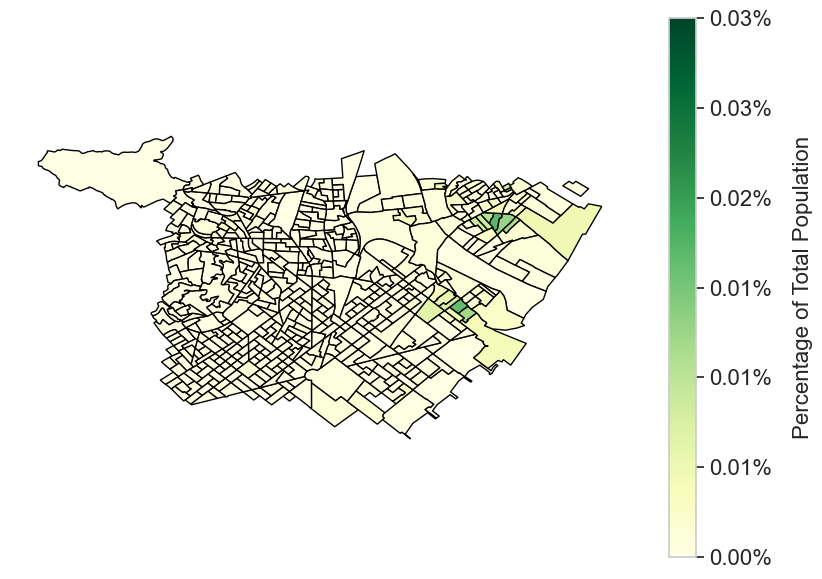

In [225]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the desired limits for the zoomed-in area for Barcelona
xmin, xmax = 2.16, 2.24  # Longitude limits
ymin, ymax = 41.4, 41.44  # Latitude limits

# Filter data to include only points within the desired limits
to_plot_zoomed = to_plot.cx[xmin:xmax, ymin:ymax]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
to_plot_zoomed.plot(column='population', cmap='YlGn', legend=False, ax=ax, edgecolor='black', linewidth=1,vmin=0, vmax=0.03)  # Set vmin and vmax to ensure correct color scaling

# Customize color bar ticks
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.2f}%")
cbar = ax.get_figure().colorbar(ax.collections[0], format=formatter, shrink=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Percentage of Total Population', fontsize=16, labelpad=15)

# Set aspect ratio
ax.set_aspect('equal')

# Remove axes
ax.set_axis_off()

# Show plot
plt.show()


In [226]:
to_plot=mapping[(mapping.year=='2022') & (mapping.cob=='Pakistán')]
to_plot.perc_population=to_plot.perc_population*100

In [227]:
to_plot.population=to_plot.population/to_plot.population.sum()

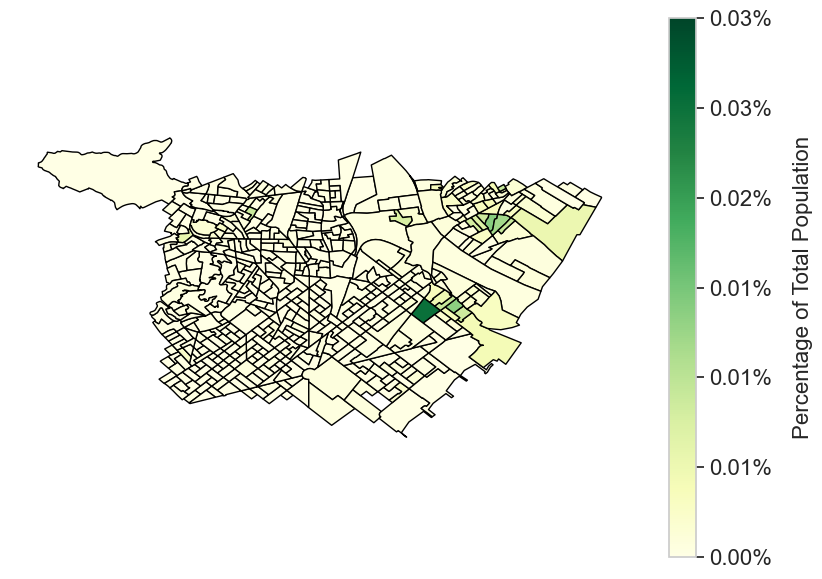

In [228]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the desired limits for the zoomed-in area for Barcelona
xmin, xmax = 2.16, 2.24  # Longitude limits
ymin, ymax = 41.4, 41.44  # Latitude limits

# Filter data to include only points within the desired limits
to_plot_zoomed = to_plot.cx[xmin:xmax, ymin:ymax]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
to_plot_zoomed.plot(column='population', cmap='YlGn', legend=False, ax=ax, edgecolor='black', linewidth=1,vmin=0, vmax=0.03)  # Set vmin and vmax to ensure correct color scaling

# Customize color bar ticks
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:.2f}%")
cbar = ax.get_figure().colorbar(ax.collections[0], format=formatter, shrink=0.7)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Percentage of Total Population', fontsize=16, labelpad=15)

# Set aspect ratio
ax.set_aspect('equal')

# Remove axes
ax.set_axis_off()

# Show plot
plt.show()